In [1]:
# Import every package we need

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [33]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import prim, dimensional_stacking, cart
from ema_workbench.util import ema_logging, utilities

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [17]:
from visualization_functions import histogram_maker, mean_outcomes, aggregate_outcomes, scatter_maker, pairplot_maker, boxplot_histogram_maker

In [5]:
import pickle

results_MORO, convergence = pickle.load(open('Outcomes/MORO_s50_nfe20000.pkl', 'rb'))

In [6]:
# Initialize model parameters
from model.dike_model_function import DikeNetwork  # @UnresolvedImport
from model.problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(5)

In [7]:
results_MORO

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Damage Score,Deaths Score,Dike Invest Score,RfR Invest Score,Evac Score
0,0,0,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.964370e+14,1.861056e-06,1.196531e+18,1.178112e+16,3.252648e+08
1,1,1,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.133849e+11,1.143893e-07,1.196531e+18,9.305655e+18,0.000000e+00
2,0,0,1,0,0,0,1,1,1,0,...,3,2,2,1,1,7.853715e+11,9.160793e-08,1.196531e+18,6.272040e+18,1.574746e+06
3,0,0,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.964370e+14,1.292400e-04,1.196531e+18,1.178112e+16,0.000000e+00
4,0,0,0,0,0,0,0,1,1,0,...,3,2,2,1,1,1.980599e+14,1.307336e-04,1.196531e+18,7.906444e+17,0.000000e+00
5,0,0,0,0,0,0,0,0,0,0,...,3,2,2,1,1,4.577942e+14,3.845736e-04,1.501146e+18,0.000000e+00,0.000000e+00
6,0,0,0,0,0,0,0,0,0,0,...,3,2,2,1,1,4.577942e+14,8.652907e-06,1.501146e+18,0.000000e+00,2.928564e+08
7,0,0,0,0,0,0,0,0,0,0,...,3,2,2,1,1,4.577942e+14,5.537860e-06,1.501146e+18,0.000000e+00,4.520066e+08
8,0,0,0,0,0,0,0,0,0,0,...,3,2,2,1,1,1.161485e+15,7.686822e-04,1.196531e+18,0.000000e+00,0.000000e+00


In [9]:
policies = []
for row in range(results.shape[0]):
    policies.append(
        Policy(name = row, **results_MORO.iloc[row,:-5].to_dict())  # Do not include the damage scores
    )

In [10]:
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=50,policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 50 scenarios * 9 policies * 1 model(s) = 450 experiments
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 135 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 225 cases completed
[MainProcess/INFO] 270 cases completed
[MainProcess/INFO] 315 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 405 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [13]:
# from ema_workbench.util.utilities import (save_results, load_results)

# save_results(results, "Outcomes/MOROpolicies50Scenarios.csv" )

[MainProcess/INFO] results saved successfully to C:\Users\newbi\project-local\Model-based-decision-making\Outcomes\MOROpolicies50Scenarios.csv


In [19]:
from ema_workbench.util.utilities import (save_results, load_results)

results = load_results('Outcomes/MOROpolicies50Scenarios.csv')

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results = results.drop(columns="model")
# results = results.apply(pd.to_numeric)
results.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\newbi\project-local\Model-based-decision-making\Outcomes\MOROpolicies50Scenarios.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,127.0,259.003109,1.0,0.421409,213.671321,1.5,0.448436,135.833228,10.0,0.161736,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
1,22.0,191.168901,10.0,0.260907,118.779549,1.0,0.177489,171.354095,10.0,0.733073,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
2,19.0,171.660267,1.0,0.832451,61.004725,1.5,0.087174,280.106934,10.0,0.518614,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
3,76.0,181.444232,1.5,0.142348,283.583457,1.5,0.009052,73.406157,1.5,0.012465,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
4,92.0,301.583109,1.5,0.787057,172.858708,10.0,0.820435,144.178460,1.0,0.253245,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0


Plot Expected Annual Damage(Histogram)
This is timestep 0


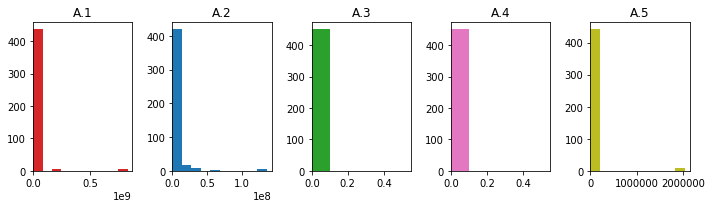

This is timestep 1


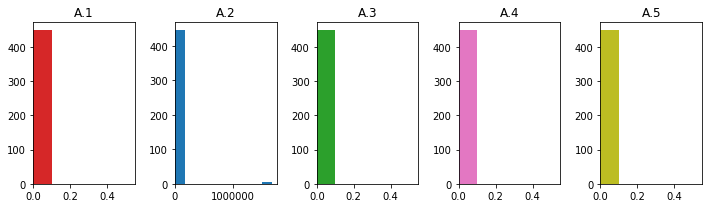

This is timestep 2


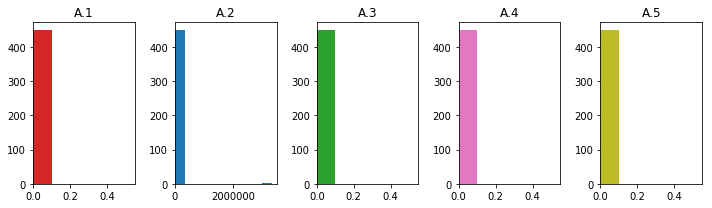

Plot Expected Number of Deaths(Histogram)
This is timestep 0


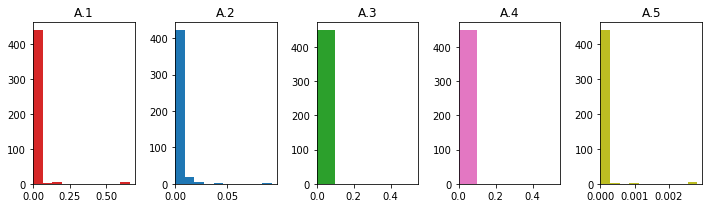

This is timestep 1


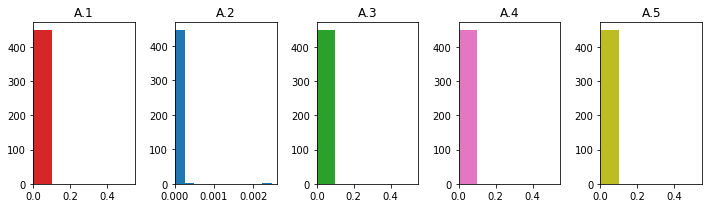

This is timestep 2


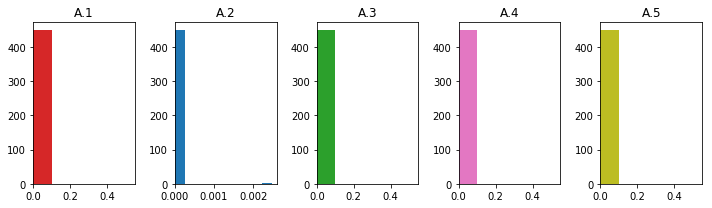

In [21]:
histogram_maker(results, "Expected Annual Damage")
histogram_maker(results, "Expected Number of Deaths")

No handles with labels found to put in legend.


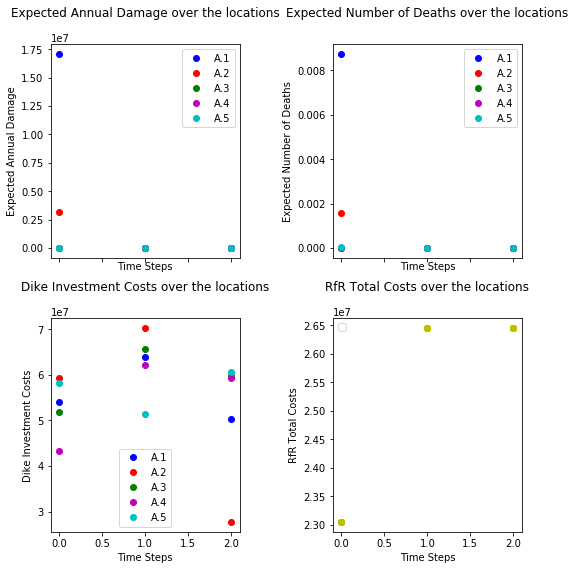

In [22]:
mean_outcomes(results)

Caution when looking at the plots, because the legend is not fixed! 

Plot Expected Annual Damage(Scatterplot)
This is timestep 0


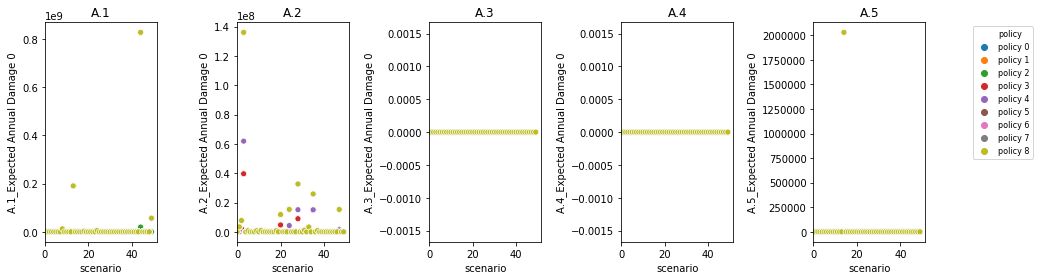

This is timestep 1


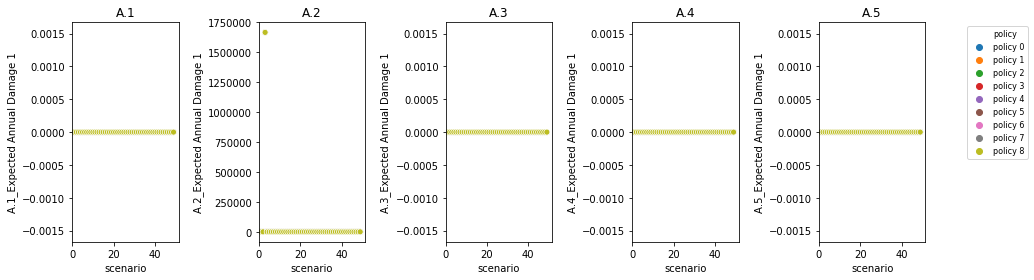

This is timestep 2


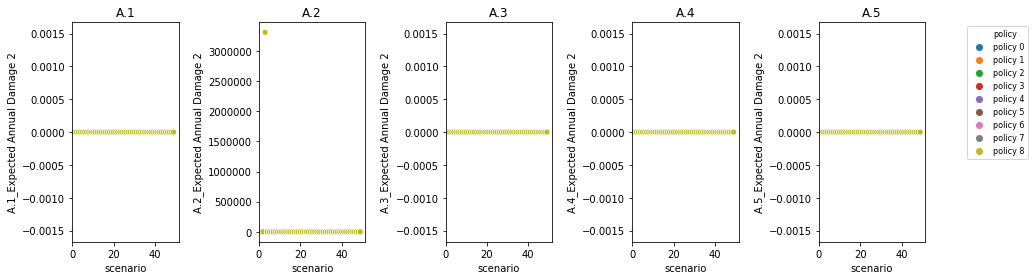

Plot Expected Number of Deaths(Scatterplot)
This is timestep 0


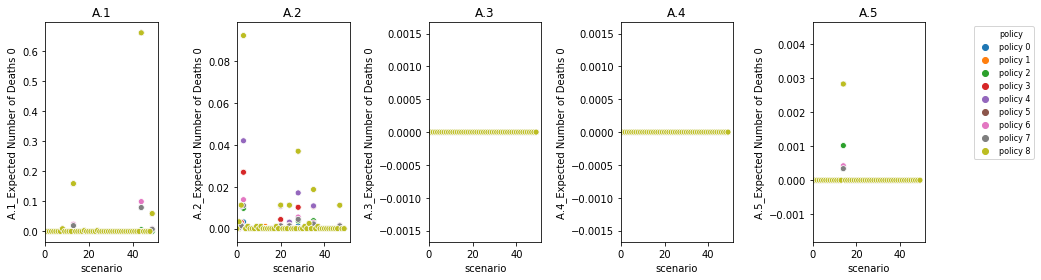

This is timestep 1


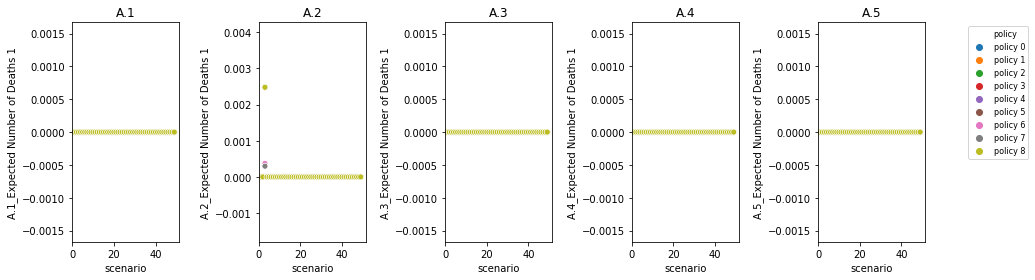

This is timestep 2


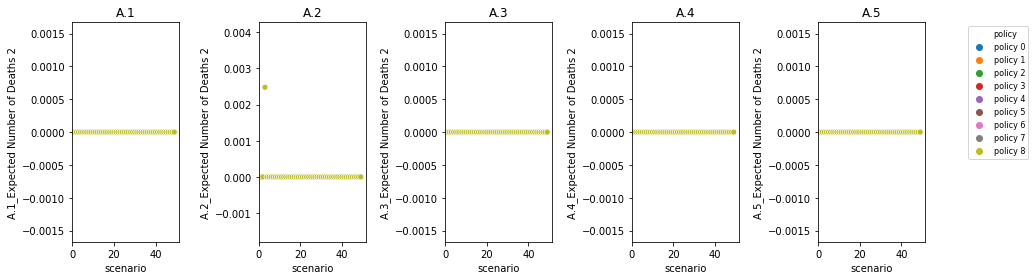

In [26]:
scatter_maker(results, "Expected Annual Damage")
scatter_maker(results, "Expected Number of Deaths")

C:\Users\newbi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\newbi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


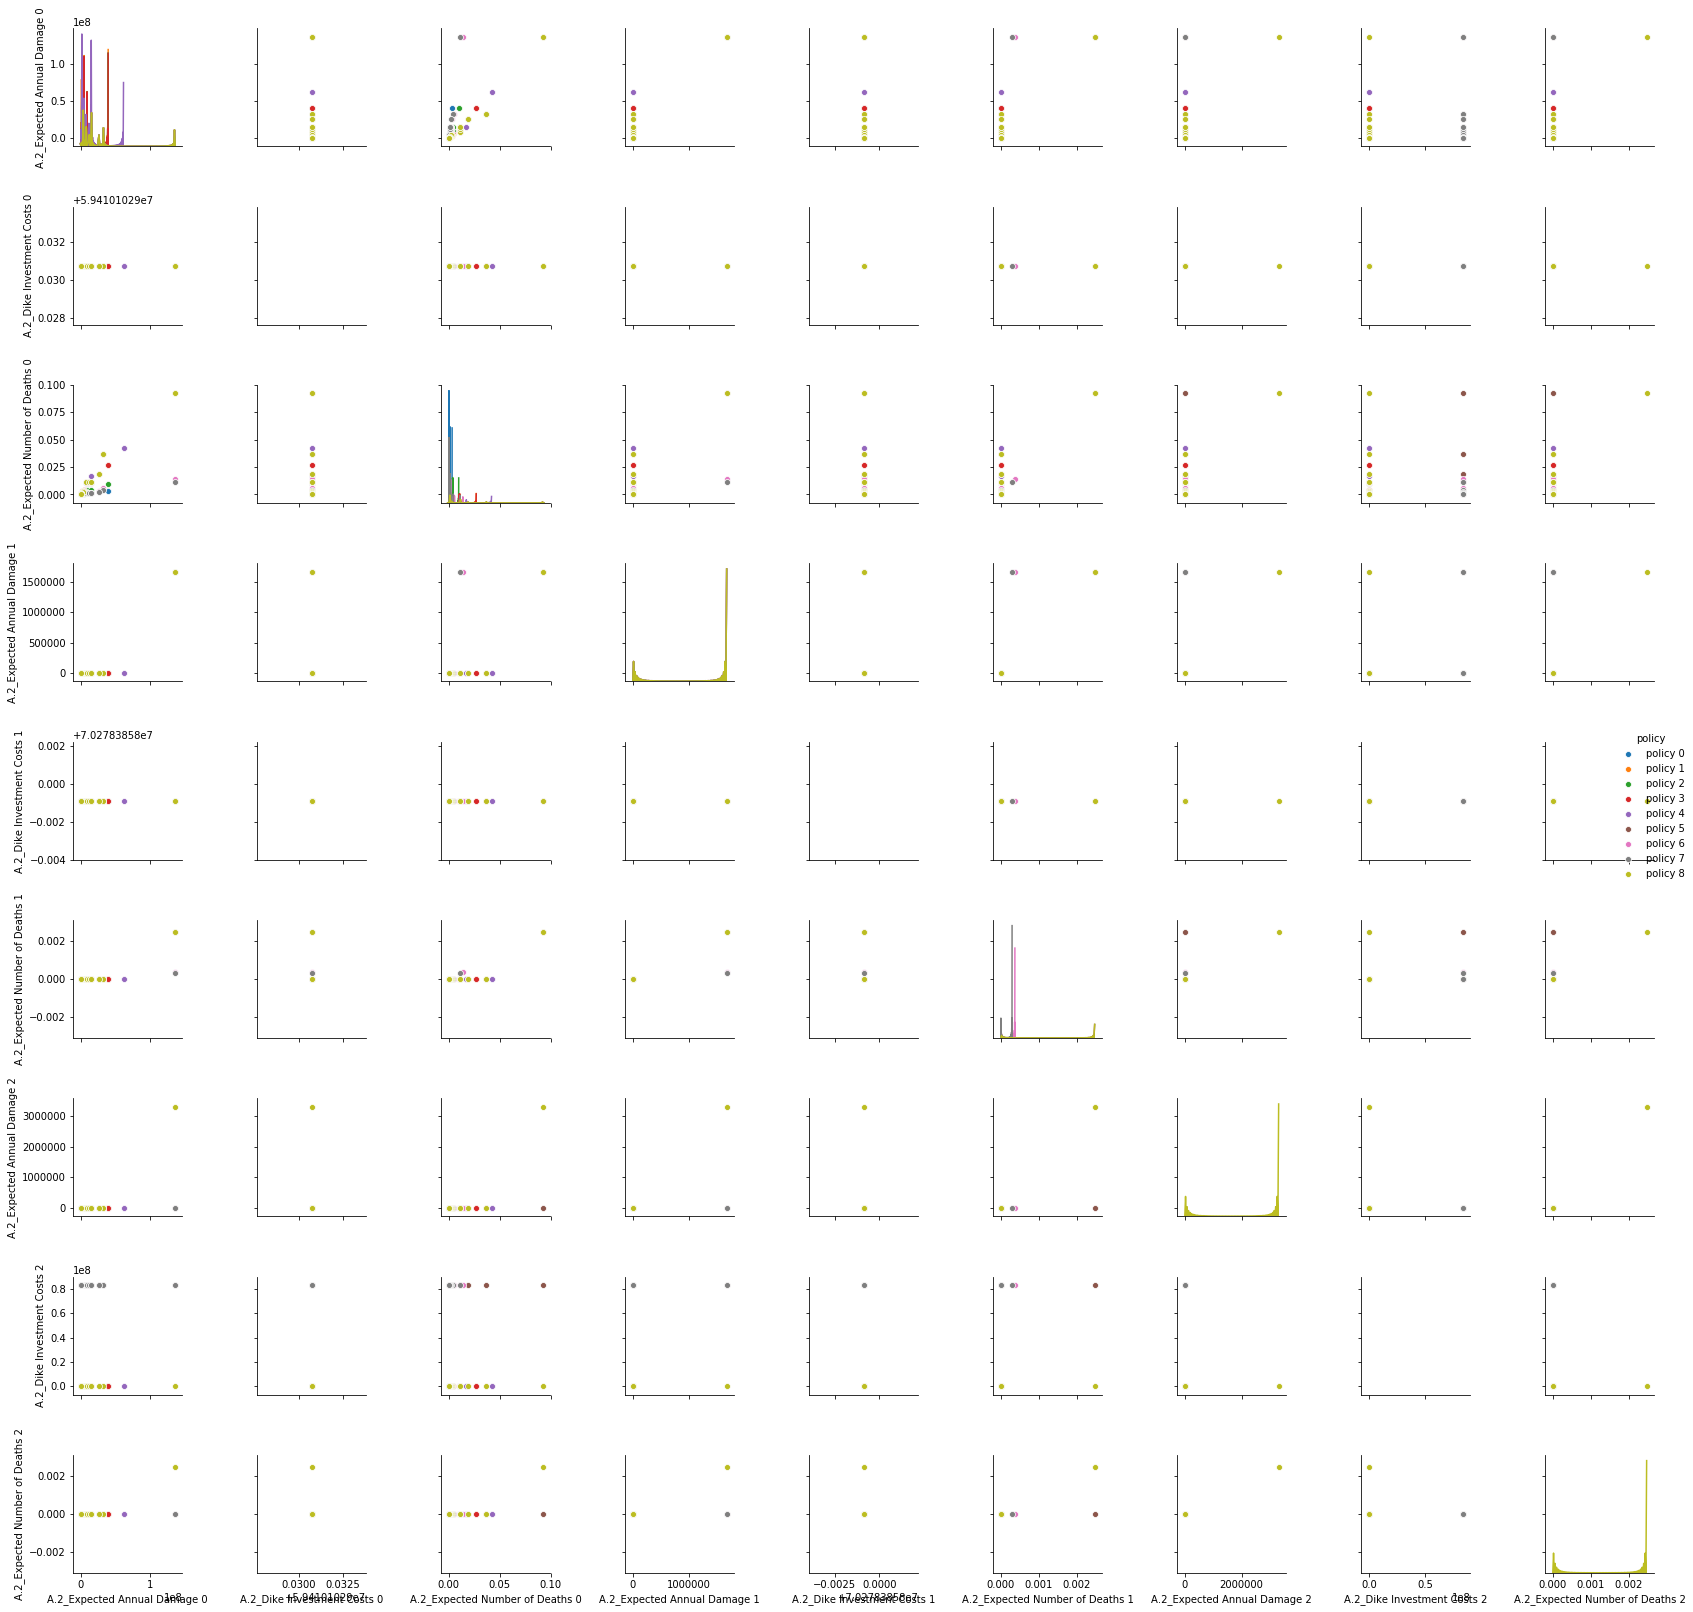

In [27]:
pairplot_maker(results, "A.2")

## Scenario Discovery

In [28]:
aggregate_outcomes(results, "Expected Number of Deaths")
aggregate_outcomes(results, "Expected Annual Damage")

Total Expected Number of Deaths First quantile: 0.0
Total Expected Number of Deaths Mean: 0.02074144993216689
Total Expected Annual Damage First quantile: 0.0
Total Expected Annual Damage Mean: 40708339.680162825


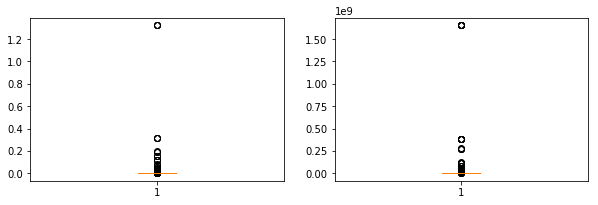

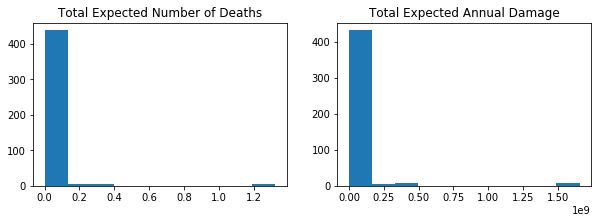

In [29]:
boxplot_histogram_maker(results)

In [35]:
x = results.iloc[:, :19] # Only take the uncertentainties 

y_deaths = results['Total Expected Number of Deaths'].values
y_deaths = y_deaths > np.percentile(y_deaths, 95)

[MainProcess/INFO] 450 points remaining, containing 23 cases of interest
[MainProcess/INFO] mean: 0.5925925925925926, mass: 0.06, coverage: 0.6956521739130435, density: 0.5925925925925926 restricted_dimensions: 4


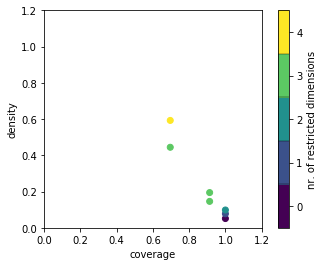

In [42]:
prim_alg = prim.Prim(x, y_deaths, threshold=0.55, peel_alpha=0.005)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

coverage    0.695652
density     0.592593
id                 6
mass            0.06
mean        0.592593
res_dim            4
Name: 6, dtype: object

                                   box 6                   \
                                     min              max   
A.3_Brate                          {1.5}            {1.5}   
discount rate 1               {2.5, 4.5}       {2.5, 4.5}   
A.0_ID flood wave shape               46              131   
discount rate 2          {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}   

                                                        
                                             qp values  
A.3_Brate                [5.953694084884149e-06, -1.0]  
discount rate 1          [0.0001975621189717138, -1.0]  
A.0_ID flood wave shape    [0.08803132780225337, -1.0]  
discount rate 2             [0.5820059396399742, -1.0]  



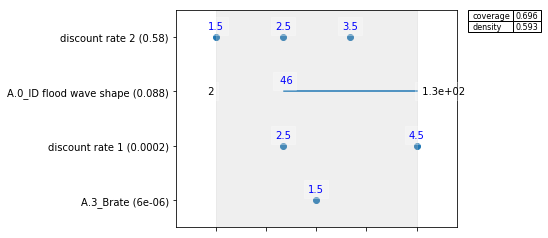

In [43]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

A.3_Brate [1.5, 1.0, 10.0]
discount rate 1 [2.5, 4.5, 1.5, 3.5]
discount rate 2 [1.5, 2.5, 3.5, 4.5]


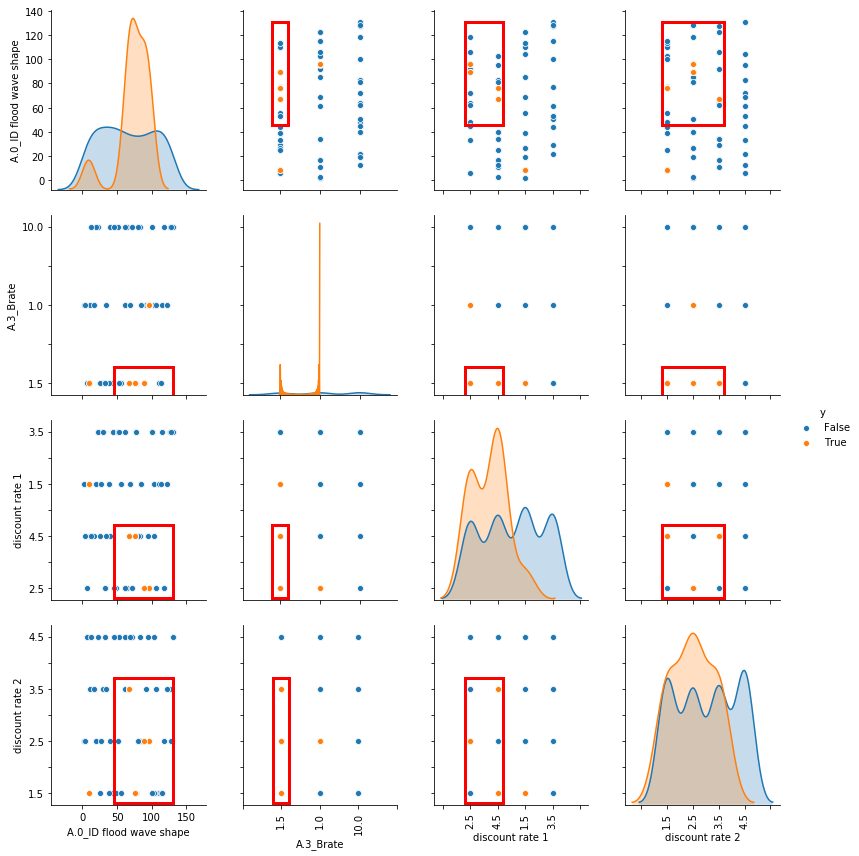

In [44]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

## Further investigation on specific locations

Check A.1 as well..

Further discovery of location A2 and time step 1 as the scatter plots and histograms showed that the policies are not robust yet. 

In [94]:
y_deaths_A1 = results["A.1_Expected Number of Deaths 0"]
y_deaths_A1 = y_deaths_A1 > np.percentile(y_deaths_A1, 90)

[MainProcess/INFO] 450 points remaining, containing 44 cases of interest
[MainProcess/INFO] mean: 0.8222222222222222, mass: 0.1, coverage: 0.8409090909090909, density: 0.8222222222222222 restricted_dimensions: 5


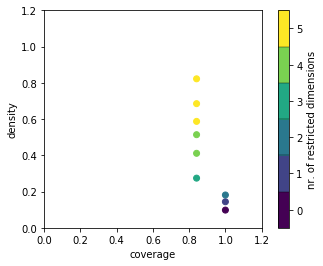

In [95]:
prim_alg = prim.Prim(x, y_deaths_A1, threshold=0.40, peel_alpha=0.0001)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

A.1_Brate [1.0, 1.5, 10.0]
A.4_Brate [10.0, 1.5, 1.0]
discount rate 1 [2.5, 3.5, 4.5, 1.5]
discount rate 2 [2.5, 3.5, 1.5, 4.5]


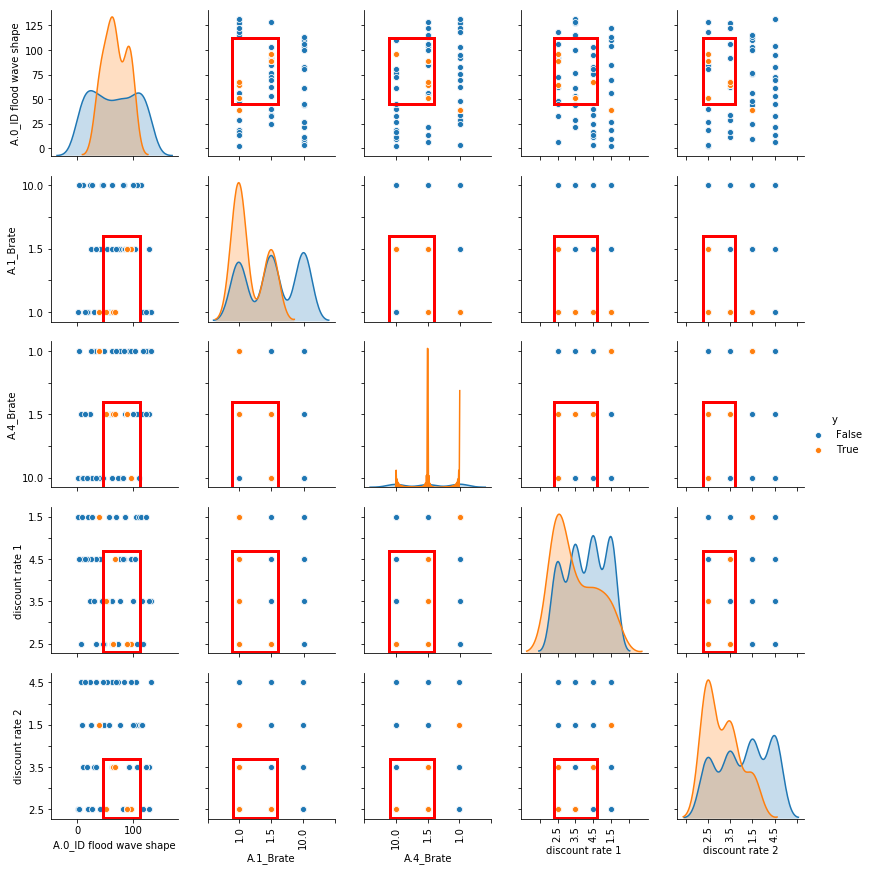

In [96]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_deaths_A1, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

In [101]:
y_damages_A1 = results["A.1_Expected Annual Damage 0"]
y_damages_A1 = y_damages_A1 > np.percentile(y_damages_A1, 90)

[MainProcess/INFO] 450 points remaining, containing 44 cases of interest
[MainProcess/INFO] mean: 0.8222222222222222, mass: 0.1, coverage: 0.8409090909090909, density: 0.8222222222222222 restricted_dimensions: 5


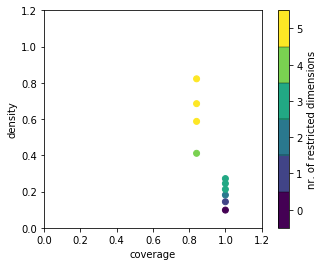

In [103]:
prim_alg = prim.Prim(x, y_deaths_A1, threshold=0.40, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

A.1_Brate [1.0, 1.5, 10.0]
A.4_Brate [10.0, 1.5, 1.0]
discount rate 1 [2.5, 3.5, 4.5, 1.5]
discount rate 2 [2.5, 3.5, 1.5, 4.5]


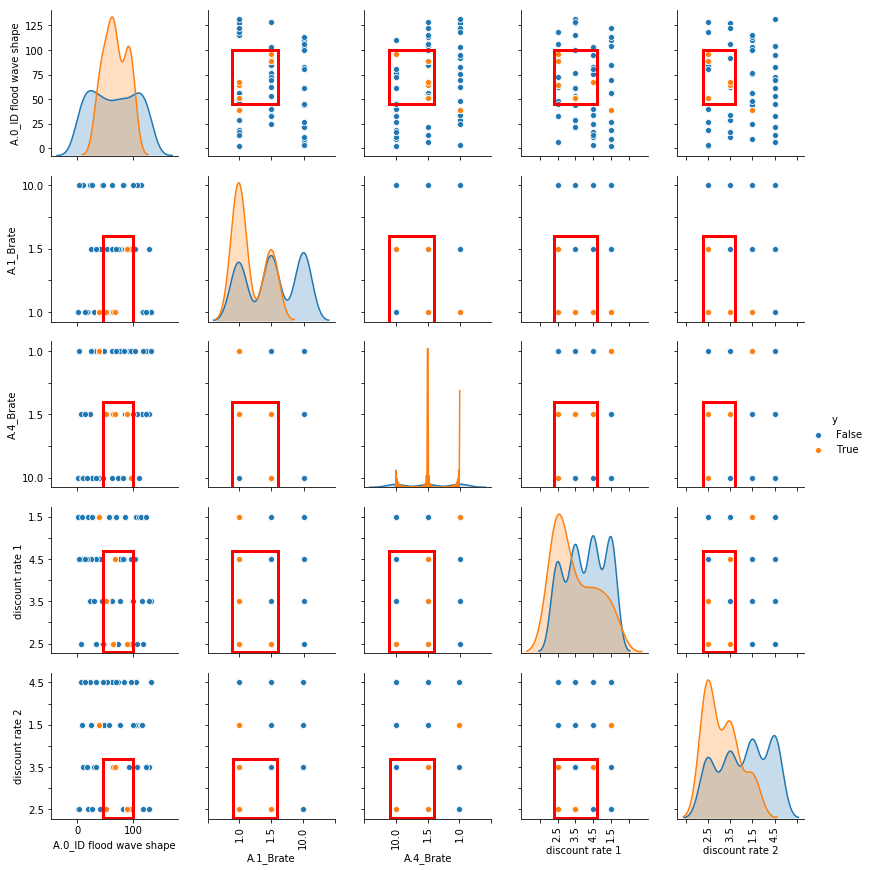

In [104]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_damages_A1, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

## A.2

In [70]:
# A.2_Expected Annual Damage 0
# A.2_Expected Number of Deaths 0

y_deaths_A2 = results["A.2_Expected Number of Deaths 0"]
y_deaths_A2 = y_deaths_A2 > np.percentile(y_deaths_A2, 90)

[MainProcess/INFO] 450 points remaining, containing 45 cases of interest
[MainProcess/INFO] mean: 0.9259259259259259, mass: 0.06, coverage: 0.5555555555555556, density: 0.9259259259259259 restricted_dimensions: 5


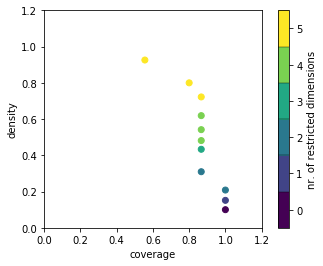

In [72]:
prim_alg = prim.Prim(x, y_deaths_A2, threshold=0.40, peel_alpha=0.0001)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

coverage    0.555556
density     0.925926
id                10
mass            0.06
mean        0.925926
res_dim            5
Name: 10, dtype: object

                              box 10               \
                                 min          max   
A.2_pfail                 0.00905152    0.0951231   
A.0_ID flood wave shape            2         78.5   
A.3_Brate                      {1.5}        {1.5}   
A.4_Brate                {1.0, 10.0}  {1.0, 10.0}   
discount rate 1           {1.5, 4.5}   {1.5, 4.5}   

                                                       
                                            qp values  
A.2_pfail                [-1.0, 0.000401045728606935]  
A.0_ID flood wave shape    [-1.0, 0.6768100146786495]  
A.3_Brate                 [0.07177997053961863, -1.0]  
A.4_Brate                  [0.6768100146786495, -1.0]  
discount rate 1            [0.6768100146786495, -1.0]  



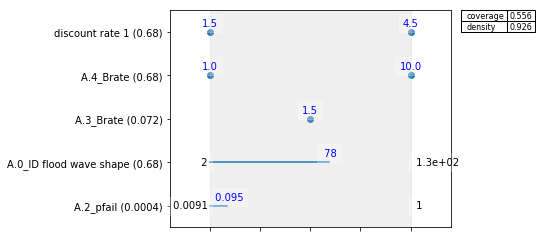

In [73]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

A.3_Brate [1.5, 1.0, 10.0]
A.4_Brate [1.0, 10.0, 1.5]
discount rate 1 [1.5, 4.5, 2.5, 3.5]


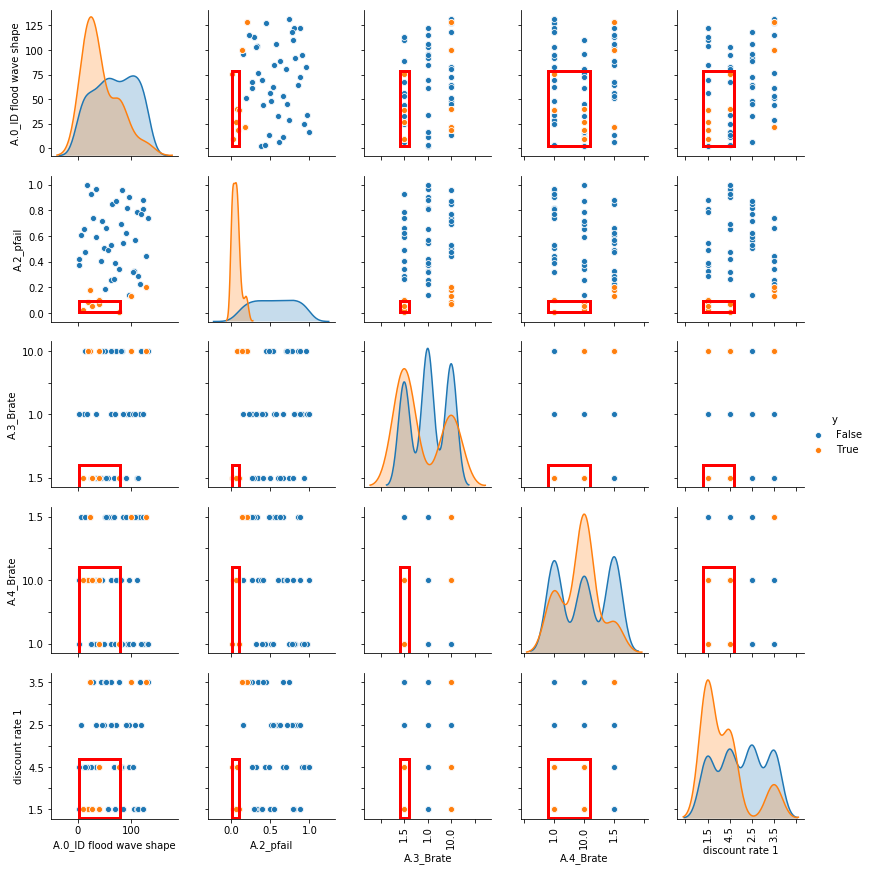

In [74]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_deaths_A2, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

In [77]:
y_damages_A2 = results["A.2_Expected Annual Damage 0"]
y_damages_A2 = y_damages_A2 > np.percentile(y_damages_A2, 90)

[MainProcess/INFO] 450 points remaining, containing 45 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.06, coverage: 0.6, density: 1.0 restricted_dimensions: 7


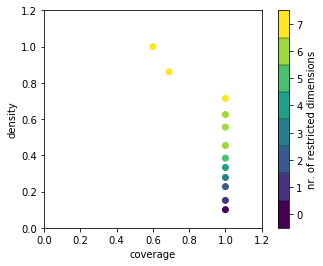

In [82]:
prim_alg = prim.Prim(x, y_damages_A2, threshold=0.40, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

A.2_Brate [1.5, 10.0, 1.0]
A.3_Brate [1.5, 1.0, 10.0]
discount rate 1 [1.5, 3.5, 4.5, 2.5]
discount rate 2 [1.5, 2.5, 3.5, 4.5]


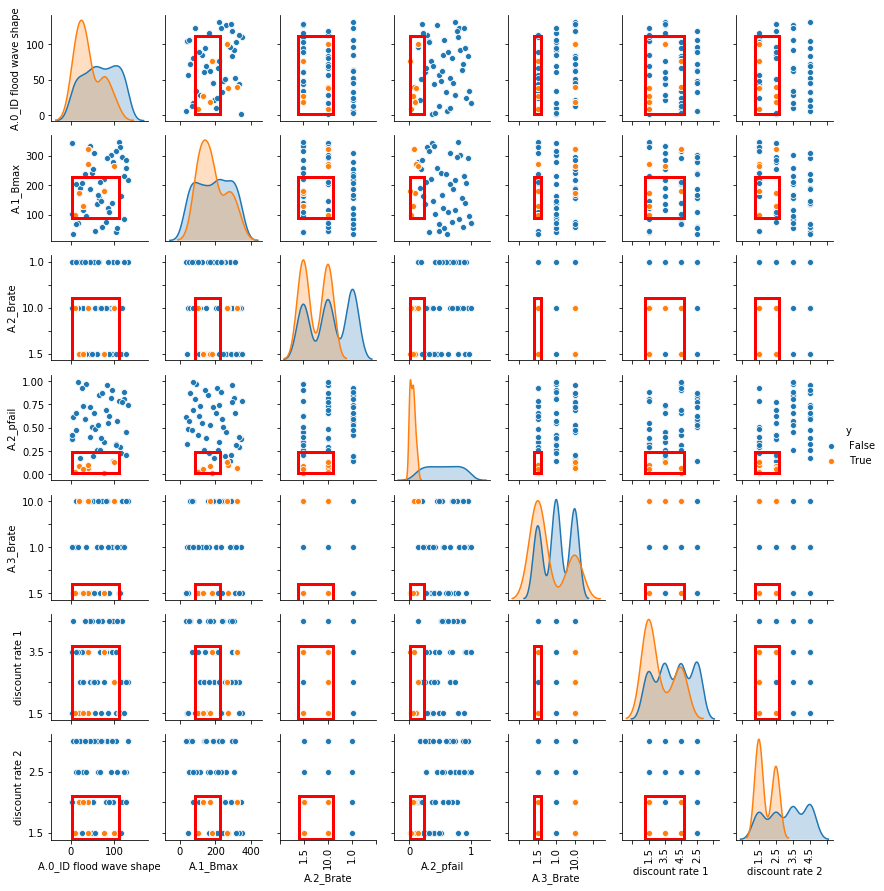

In [83]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
# PCA: same coverage

# x_numeric = x.select_dtypes(exclude=pd.CategoricalDtype)
# x_categorical = x.select_dtypes(include=pd.CategoricalDtype)

# rotated_experiments, rotation_matrix = prim.pca_preprocess(x_numeric, y_damages_A2)

# rotated_x = pd.concat([rotated_experiments, x_categorical], axis=1)

# prim_obj = prim.Prim(rotated_x, y_damages_A2, threshold=0.1, peel_alpha=0.1)
# box1 = prim_obj.find_box()

# box1.show_tradeoff()
# plt.show()

In [ ]:
cart_alg = cart.CART(x, y_damages_A2, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()